In [142]:
from random import randrange
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', context='notebook')
sns.set_color_codes('dark')

k = 1

sd = int(dt.datetime(2016, 8, 4).timestamp())
team_num = 10
times = []
for i in range(team_num):
    times.append([randrange(2), dt.datetime.fromtimestamp(sd + 60 * int(randrange(14400 + 7200) / 60))])
    
df = pd.DataFrame(times, columns = ['tt', 'time'])
names = ['Alice', 'Bob', 'Clark', 'David', 'Ed', 'Frank', 'George', 'Helen', 'Ivan', 'John', 'Kelly', 'Lance', 'Mario',
        'Nolan', 'Oleg', 'Paul', 'Quentin', 'Ricky', 'Steve', 'Thomas', 'Ulaf', 'Valera', 'Wayne', 'Xi', 'Yang', 'Zed']
df['ts'] = df.time.apply(lambda x: int(x.timestamp()))
df['ts_norm'] = (df.ts - df.ts.mean()) / k
df = df.sort_values('ts').reset_index()
df['name'] = names[:team_num]
df.drop('index', axis=1, inplace=True)
df

,tt,time,ts,ts_norm,name
0,1,2016-08-04 01:45:00,1470264300,-7854,Alice
1,0,2016-08-04 02:17:00,1470266220,-5934,Bob
2,0,2016-08-04 02:42:00,1470267720,-4434,Clark
3,1,2016-08-04 03:09:00,1470269340,-2814,David
4,1,2016-08-04 03:10:00,1470269400,-2754,Ed
5,0,2016-08-04 04:24:00,1470273840,1686,Frank
6,0,2016-08-04 04:57:00,1470275820,3666,George
7,1,2016-08-04 05:15:00,1470276900,4746,Helen
8,1,2016-08-04 05:43:00,1470278580,6426,Ivan
9,1,2016-08-04 05:57:00,1470279420,7266,John


In [143]:
slot_num = 4
times = []
for i in range(slot_num):        
    times.append([randrange(2), dt.datetime.fromtimestamp(sd + 7200 + 60 * int(randrange(7200) / 60))])
    
df_slot = pd.DataFrame(times, columns = ['tt', 'time'])
df_slot = df_slot.sort_values('time')
train_names = ['train' + str(x) for x in np.arange(slot_num)]
df_slot['name'] = train_names
df_slot['ts'] = df_slot.time.apply(lambda x: int(x.timestamp()))
df_slot['ts_norm'] = (df_slot.ts - df_slot.ts.mean()) / k
norm_sh = df.ts_norm.min() - df_slot.ts_norm.min()
df_slot['ts_norm_shift'] = df_slot.ts_norm + norm_sh
df_slot = df_slot.reset_index().drop('index', axis=1)
df_slot

,tt,time,name,ts,ts_norm,ts_norm_shift
0,1,2016-08-04 02:07:00,train0,1470265620,-3240,-7854
1,0,2016-08-04 02:57:00,train1,1470268620,-240,-4854
2,1,2016-08-04 03:11:00,train2,1470269460,600,-4014
3,1,2016-08-04 03:49:00,train3,1470271740,2880,-1734


In [148]:
def new_util(x):
    u = []
    t_t = x.ts_norm
    for t_i in train_times:
        add = 0 if x.tt == 1 else 1 - (t_i - t_t) / 15000        
        delta = (t_i - t_t) / 3600       
        util = np.exp(-(delta ** 2)) + 0.2 * add
        u.append(util)
    return pd.Series(u)

def prev_util(x):
    #t_t = x.ts
    t_t = x.ts_norm
    u = []
    #t_0 = df_slot[df_slot.ts >= t_t].ts.min()
    t_0 = df_slot[df_slot.ts_norm >= t_t].ts.min()
    for t_i in train_times:
        if t_t > t_i:
            util = 0
        else:
            add = 0 if x.tt == 1 else 1 - (t_i - t_t) / 150
            #util = np.round(((t_0 - t_t) / np.exp((t_i - t_0))) / 1000 + 1.0 * add, 3)            
            #util = (t_0 - t_t) / 
        u.append(util)
    return pd.Series(u) 

def get_util(x):
    t_t = x.ts
    u = []
    for t_i in train_times:        
        #print(t_i - t_t, add)
        if (team_num < slot_num) & (t_t > t_i):
            add = 1 - np.exp(-0.5*((t_i - t_t))**2)
            util = 1.0 + 0.1 * add
        else:
            add = 0 if x.tt == 1 else 1 - (t_i - t_t) / 150
            if (x.tt == 1) & (t_t > t_i):
                k = 20
            else:
                k = 5        
            delta_h = (t_t - t_i)
            util = np.exp(-(delta_h ** 2) / k) + 0.1 * add
        u.append(util)
    return pd.Series(u)    
    

df.drop([x for x in df.columns if 'train' in x], axis=1, inplace=True)
train_list = sorted(df_slot.name.unique())
#train_times = list(df_slot.ts.values)
train_times = list(df_slot.ts_norm_shift.values)
df[train_list] = df.apply(lambda x: new_util(x), axis=1)

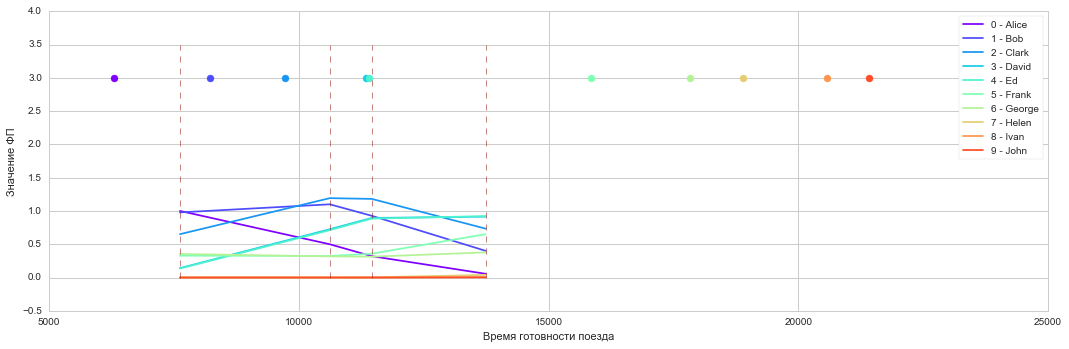

In [145]:
plt.figure(figsize=(15, 5))
cmap = matplotlib.cm.rainbow
for i in range(len(df.index)):
    plt.plot(df_slot.ts - sd, df.ix[i][train_list], label='%d - %s' % (i, df.ix[i]['name']), color=cmap(i / float(team_num)))
    plt.scatter(df.ix[i].ts - sd, 3.0, color=cmap(i / float(team_num)), s=50)

plt.xlabel('Время готовности поезда')
plt.ylabel('Значение ФП')
for t in df_slot.ts.values:
    plt.plot([t - sd] * 100, np.linspace(0, 3.5, 100), 'r--', lw=0.5)
    
#plt.xticks(df_slot.ts, df_slot.time, rotation=45)
plt.legend(loc='best', frameon=True)
plt.tight_layout()

In [146]:
from scipy import optimize
row, col = optimize.linear_sum_assignment(-df[train_list].as_matrix())
print(sorted(list(zip(['train %d' % t for t in col], df.ix[row].name))))
df['bt'] = -1
df.ix[row, 'bt'] = col

def get_max(row):
    l = row[train_list]
    is_max = row.index == ('train' + str(int(row.bt)))    
    return ['background-color: yellow' if v else '' for v in is_max]    

print(df_slot[['name', 'time', 'ts_norm']])
df.sort_values('ts').style.apply(get_max, axis=1)

[('train 0', 'Alice'), ('train 1', 'Bob'), ('train 2', 'Clark'), ('train 3', 'Ed')]
     name                time  ts_norm
0  train0 2016-08-04 02:07:00    -3240
1  train1 2016-08-04 02:57:00     -240
2  train2 2016-08-04 03:11:00      600
3  train3 2016-08-04 03:49:00     2880


In [125]:
a = pd.melt(df.sort_values('ts').reset_index()[train_list])
a.columns = ['train', 'util']
a['train'] = a.train.apply(lambda x: int(x[-1]))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure().gca(projection='3d')
#ax = fig.add_subplot(111, projection='3d')

fig.scatter(a.index, a.train, a.util, c='r', marker='o')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

plt.show()

In [ ]:
x = np.linspace(0, 4, 100)
plt.figure(figsize=(12, 5))
t_0 = 2
x1 = np.array([i for i in x if i >= t_0])
x2 = np.array([i for i in x if i < t_0])
for k in [5, 20]:
    y1 = np.exp(-((x1 - t_0)**2) / k)
    y2 = np.exp(-((x2 - t_0)**2) / 50)
    plt.scatter(x1, y1, color=cmap(k / float(100)), s=5, label='k=%d' % k)
    plt.scatter(x2, y2, color=cmap(k / float(100)), s=5, label='k=%d' % k)
#k = [ for i in x ]
plt.ylim(-0.2, 1.2)
plt.legend()